In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy.optimize import minimize

Load generator.

In [2]:
gen = tf.keras.models.load_model("/home/bthorne/projects/gan/kevin/generator.h5")

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


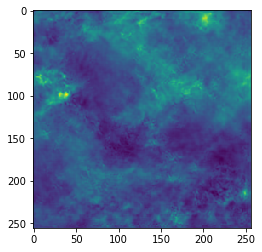

In [3]:
np.random.seed(100)
z_in = np.random.randn(1, 64)
example = gen.predict(z_in)

fig, ax = plt.subplots(1, 1)
ax.imshow(example[0, :, :, 0])

# Backward model

To go from a dust map to the realization, $\mathbf{z}$, we need a model for the noise. Under the assumption that there is no reconstruction error, and that there is no noise in the map.

In [4]:
def loss(z):
    img = objective_function(z)
    return L2(img, example)

def L2(img1, img2):
    return np.linalg.norm(img1 - img2)
    #return np.sum((img1 - img2) ** 2)

def L2_callback(x):
    assert x.ndim == 1
    n_opt = len(x)
    z = np.zeros((1, 64))
    z[0, n_opt:] = z_in[0, n_opt:]
    z[0, :n_opt] = x
    print(L2(gen.predict(z), example))
    return None
    
def objective_function(x):
    assert x.ndim == 1
    n_opt = len(x)
    z = np.zeros((1, 64))
    z[0, n_opt:] = z_in[0, n_opt:]
    z[0, :n_opt] = x
    return gen.predict(z)

In [10]:
n_opt = 2

In [13]:
z_0 = np.random.randn(n_opt) * 0.1

z_near = np.copy(z_in)
z_near[0, :n_opt] = z_0[:n_opt]

# BFGS, CG do not work. Nelder-Mead is the only optimization that worked as expected.
res = minimize(loss, z_0, method="BFGS", tol=1e-4, callback=L2_callback, options={'maxiter': 200})

print("True z_0:", z_in[0, :n_opt])
print("Start:", z_near[0, :n_opt])
print("Result of minimization:", res.x)

True z_0: [-1.74976547  0.3426804 ]
Start: [-0.0455922   0.06491729]
Result of minimization: [-0.0455922   0.06491729]


In [12]:
res

      fun: 12.19145679473877
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 1
     njev: 19
   status: 0
  success: True
        x: array([0.1170528 , 0.20777132])

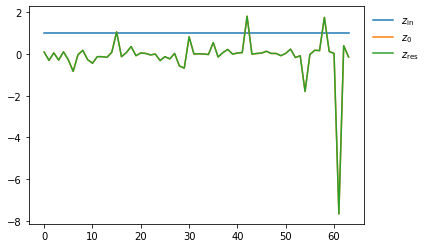

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(z_in[0, :n_opt] / z_in[0, :n_opt], label=r'$z_{\rm in}$')
ax.plot(z_near[0, :n_opt] / z_in[0, :n_opt], label=r'$z_{\rm 0}$')
ax.plot(res.x / z_in[0, :n_opt], label=r'$z_{\rm res}$')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)

In [196]:
print(L2(gen.predict(z_in), example))
print(L2(gen.predict(z_near), example))
print(L2(objective_function(res.x), example))

0.0
28.48576
3.893348


In [197]:
print(res)

 final_simplex: (array([[-1.18182769,  0.0701677 ,  0.50297614, -1.13071845],
       [-1.11502796,  0.13096772,  0.43706317, -1.16228825],
       [-1.05120773,  0.06421397,  0.42519955, -1.22187285],
       [-1.10215412,  0.15656457,  0.38196406, -1.23106393],
       [-1.16499983,  0.03850268,  0.33617801, -1.23609367]]), array([3.89334798, 4.18052959, 4.38024092, 4.39689445, 4.46930408]))
           fun: 3.893347978591919
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 337
           nit: 200
        status: 2
       success: False
             x: array([-1.18182769,  0.0701677 ,  0.50297614, -1.13071845])


Text(0.5, 1.0, 'Minimization starting point')

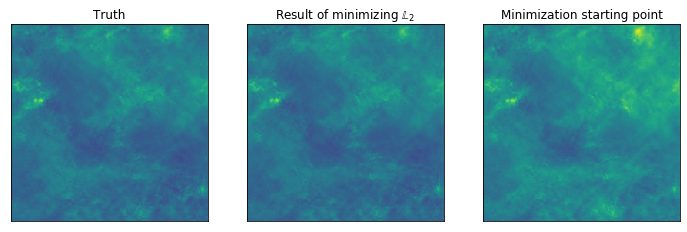

In [198]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
plt.subplots_adjust(hspace=0.1)
for a in ax:
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
    #a.axis('off')
ax[0].imshow(example[0, :, :, 0], vmin=-0.9, vmax=0.4)
ax[0].set_title('Truth')
ax[1].imshow(objective_function(res.x)[0, :, :, 0], vmin=-0.9, vmax=0.4)
ax[1].set_title(r'Result of minimizing $\mathbb{L}_2$')
ax[2].imshow(gen.predict(z_near)[0, ..., 0], vmin=-0.9, vmax=0.4)
ax[2].set_title(r'Minimization starting point')

## Square cut out

In this section we take a subgrid of the map, upsample to the correct dimsensions, and approximate it as being a large-scale smoothing of the original image.

In [176]:
_, xpix, ypix, _ = example.shape

In [179]:
subset = example[0, :int(xpix / 2), :int(ypix / 2), 0]

In [180]:
subset.shape

(128, 128)

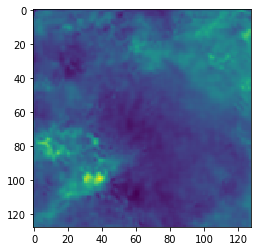

In [181]:
fig, ax = plt.subplots(1, 1)
ax.imshow(subset)

In [182]:
from scipy.ndimage import zoom

In [183]:
upsample = zoom(subset, 2, order=3)

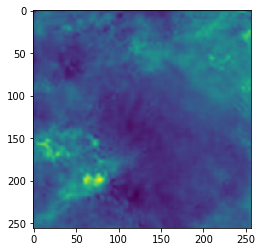

In [184]:
fig, ax = plt.subplots(1, 1)
ax.imshow(upsample)

In [226]:
def objective_function(z, target=None):
    img = generative_function(z)
    return np.linalg.norm(img - target)

def L2_callback(x):
    assert x.ndim == 1
    n_opt = len(x)
    z = np.zeros((1, 64))
    z[0, n_opt:] = z_in[0, n_opt:]
    z[0, :n_opt] = x
    print(np.linalg.norm(gen.predict(z) - example))
    
def generative_function(x):
    assert x.ndim == 1
    n_opt = len(x)
    z = np.zeros((1, 64))
    z[0, n_opt:] = z_in[0, n_opt:]
    z[0, :n_opt] = x
    return gen.predict(z)

In [230]:
z_0 = np.random.randn(n_opt) * 0.1
res = minimize(objective_function, z_0, method="Nelder-Mead", args=(upsample), options={'maxiter': 10000})

In [231]:
res.x

array([-0.02068074,  0.01494725, -0.07257495, -0.21289355,  0.17402052,
       -0.02041646,  0.14931348, -0.21338302, -0.60213129, -1.39745925,
       -0.02662409,  0.00566333, -0.02048021,  0.35982775,  0.32876992,
       -0.04188379, -0.03247615, -0.18481265,  0.35351703,  0.44049465,
       -0.97544551,  0.07107489,  0.09990453, -0.07381162,  0.01774342,
       -0.04442242, -0.56776148,  0.02918965,  0.31731781,  0.60560174,
        0.18166481,  0.09240837, -0.20669372, -0.00969192,  0.44034186,
       -0.02808556, -0.15788534,  0.1860289 , -0.20583453,  0.01733893,
       -0.93937626, -0.12611693, -0.36070325,  0.71454401, -0.44045316,
       -0.2183958 ,  0.40572861,  0.20354099,  0.10547026,  0.37095978,
       -0.14243745,  0.06321946, -0.30017325,  0.14981135, -0.86599459,
        0.08868574, -0.62156187, -0.2046582 ,  0.05506346,  0.20240008,
        1.23849081, -0.05741375,  0.167504  ,  0.66824306])

In [243]:
res = minimize(objective_function, res.x, method="Nelder-Mead", args=(upsample), options={'maxiter': 10000})

In [236]:
print(res)

 final_simplex: (array([[ 0.08683991, -0.0506083 , -0.39677711, ..., -0.26865774,
        -0.64807274, -0.50878876],
       [ 0.08522972, -0.05054809, -0.39089251, ..., -0.26684644,
        -0.63849672, -0.49987135],
       [ 0.08738526, -0.05036338, -0.38692363, ..., -0.27052368,
        -0.64187328, -0.5185719 ],
       ...,
       [ 0.08714299, -0.05017577, -0.40436887, ..., -0.26356973,
        -0.66104183, -0.51746717],
       [ 0.08798628, -0.05033519, -0.39495293, ..., -0.26833265,
        -0.6483178 , -0.50053951],
       [ 0.08722191, -0.05006604, -0.39737459, ..., -0.28058697,
        -0.66275081, -0.53096872]]), array([363.31933594, 363.31967163, 363.32034302, 363.32058716,
       363.32073975, 363.32098389, 363.3210144 , 363.32125854,
       363.3213501 , 363.32150269, 363.32247925, 363.32250977,
       363.32290649, 363.32312012, 363.32342529, 363.32357788,
       363.32373047, 363.32382202, 363.32452393, 363.32489014,
       363.32504272, 363.32519531, 363.32540894, 363.3

Text(0.5, 1.0, 'Minimization starting point')

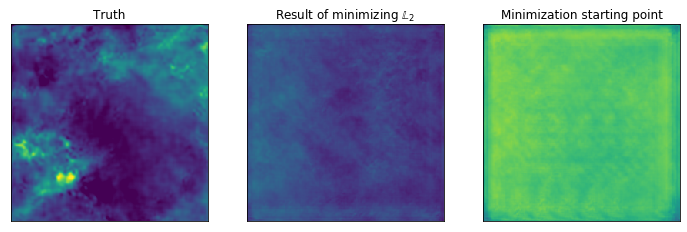

In [242]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
plt.subplots_adjust(hspace=0.1)
for a in ax:
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
    #a.axis('off')
ax[0].imshow(upsample, vmin=-0.5, vmax=0.1)
ax[0].set_title('Truth')
ax[1].imshow(generative_function(res.x)[0, :, :, 0], vmin=-0.5, vmax=0.1)
ax[1].set_title(r'Result of minimizing $\mathbb{L}_2$')
ax[2].imshow(gen.predict(z_near)[0, ..., 0], vmin=-0.5, vmax=0.1)
ax[2].set_title(r'Minimization starting point')

Text(0.5, 1.0, 'Result of minimizing $\\mathbb{L}_2$')

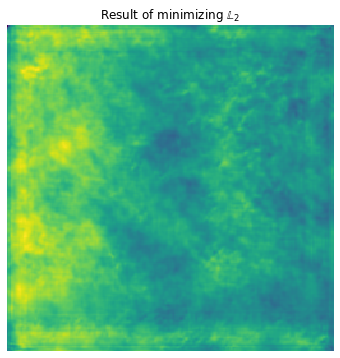

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
plt.subplots_adjust(hspace=0.1)
ax.axis('off')
ax.imshow(generative_function(res.x)[0, :, :, 0])
ax.set_title(r'Result of minimizing $\mathbb{L}_2$')